# Big Data Experiment

In [20]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier

from mlxtend.classifier import EnsembleVoteClassifier
import copy

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

%matplotlib inline

## Exploratory Analysis

In [2]:
path = 'Data/bank-full.csv'

with open(path, encoding="utf8") as f:
    data = pd.read_csv(f, sep=";", encoding="utf8")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
# previous = data['previous']
# plot_retweets = previous.plot.hist()
# plot_retweets.set_xlabel("Number of contacts performed before this campaign", weight='bold', size=12)
# plot_retweets.set_ylabel("Frequency", weight='bold', size=12)

In [6]:
# campaign = data['campaign']
# plot_retweets = campaign.plot.hist()
# plot_retweets.set_xlabel("Number of contacts during before this campaign", weight='bold', size=12)
# plot_retweets.set_ylabel("Frequency", weight='bold', size=12)

In [7]:
# pairplot = sns.pairplot(data)

In [8]:
# correlations = data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].corr()
# correlations_matrix = sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, cmap=sns.cubehelix_palette(10))

In [9]:
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [10]:
data.y.value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64

In [11]:
# Split data into training and test sets
train, test = train_test_split(data, train_size=0.9)

# Encoder
encoder = preprocessing.LabelEncoder()

In [12]:
print(train.size, test.size)

691713 76874


## Functions

In [13]:
# Add the scores to the dataframe
def add_to_results(df, n_estimators, split, dist, f1, result):
    scores = {"N_estimators": n_estimators, "Splits": split, "Distribution": dist, "F1-score": f1, "Result": result}
    df = df.append(scores, ignore_index=True)
    return df

In [14]:
# Split a data set in to X, y and encode X
def splitXy(dataset):
    X = dataset.drop('y', axis=1)
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = encoder.fit_transform(X[column])        
    y = dataset.y
    return X, y

In [15]:
# Train voting classifier with n splits
def train_classifier_with_n_splits(n_parts, train):
    # Randomly split data into n parts of (roughly) equal size
    splits = np.array_split(train, indices_or_sections=n_parts)
    
    # Fit a decision tree to every split of data
    classifiers = []
    for i, split in enumerate(splits):
        X_train, y_train = splitXy(split)

        tree_split = tree.DecisionTreeClassifier(max_depth=10)
        tree_split = tree_split.fit(X_train, y_train)
        classifiers.append(tree_split)
        
    # Combine all trees in a voting classifier
    eclf = EnsembleVoteClassifier(clfs=classifiers, voting="soft", refit=False)
    eclf.fit(None, y_train)
    
    return eclf

In [16]:
# Test voting classifier
def validate_classifier(eclf, test):
    X_test, y_test = splitXy(test)
    eclf_report = classification_report(y_test, eclf.predict(X_test), output_dict=True)
    return eclf_report

In [17]:
def my_voting_classifier(n_splits, train, test):
    # Empty dataframe to save results
    results = pd.DataFrame()

    # Repeat for every n of splits: train classifier, 
    for n_split in n_splits:
        eclf = train_classifier_with_n_splits(n_split, train)
        report = validate_classifier(eclf, test)
        results = add_to_results(results, 1, n_split, 0, report['macro avg']['f1-score'], report)
        print(n_split, report['macro avg']['f1-score'])
    
    return results

## Voting classifier, training on seperate splits

In [18]:
n_splits = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
results = my_voting_classifier(n_splits, train, test)
results

1 0.7533852620319579
2 0.6935643202855499
4 0.7285564358310712
8 0.7205830232146022
16 0.7309184543382571
32 0.7028337241807484
64 0.6791275776562468
128 0.6553488554131246
256 0.6391349453355678
512 0.6145921676820293


,Distribution,F1-score,N_estimators,Result,Splits
0,0.0,0.753385,1.0,"{'no': {'precision': 0.9402081820382474, 'reca...",1.0
1,0.0,0.693564,1.0,"{'no': {'precision': 0.926555023923445, 'recal...",2.0
2,0.0,0.728556,1.0,"{'no': {'precision': 0.9346357935359383, 'reca...",4.0
3,0.0,0.720583,1.0,"{'no': {'precision': 0.9315461943513643, 'reca...",8.0
4,0.0,0.730918,1.0,"{'no': {'precision': 0.9332695527385793, 'reca...",16.0
5,0.0,0.702834,1.0,"{'no': {'precision': 0.9263556713237036, 'reca...",32.0
6,0.0,0.679128,1.0,"{'no': {'precision': 0.9209105843698663, 'reca...",64.0
7,0.0,0.655349,1.0,"{'no': {'precision': 0.9154309545875811, 'reca...",128.0
8,0.0,0.639135,1.0,"{'no': {'precision': 0.9128122109158187, 'reca...",256.0
9,0.0,0.614592,1.0,"{'no': {'precision': 0.9085072231139647, 'reca...",512.0


Text(0.5, 0, 'Number of splits')

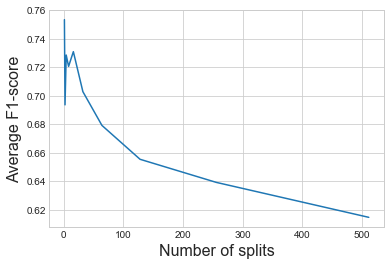

In [31]:
fig = plt.figure()
ax = plt.axes()

ax.plot(results['Splits'], results['F1-score']);
plt.ylabel('Average F1-score', size = 16)
plt.xlabel('Number of splits', size = 16)
#plt.xticks(ticks=n_splits)